In [53]:
# Import required packages
from collections import OrderedDict
import os

import pandas as pd
import earthpy as et
import geopandas as gpd
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import earthpy.plot as ep
import h5py
import json
import joypy
import plotnine as plt9
import requests
from scipy import stats
from shapely.geometry import box
import seaborn as sns
from sklearn.neighbors import KernelDensity
import matplotlib.gridspec as grid_spec


# Set working directory
directory_path = os.path.join(et.io.HOME, "earth-analytics")
os.chdir(directory_path)

# Download the data
et.data.get_data(
    url=("https://storage.googleapis.com/neon-aop-products/"
         "2020/FullSite/D13/2020_NIWO_4/L3/Spectrometer/Reflectance/"
         "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5"))

'/Users/elsa/earth-analytics/data/earthpy-downloads/NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5'

In [2]:
# Create path to hdf5 file
hdf5_path = os.path.join(
    "data", "earthpy-downloads", 
    "NEON_D13_NIWO_DP3_454000_4432000_reflectance.h5")

In [3]:
def aop_h5refl2array(refl_filename):
    """aop_h5refl2array reads in a NEON AOP reflectance hdf5 file and returns 
           1. reflectance array (with the no data value and reflectance scale factor applied)
           2. dictionary of metadata including spatial information, and wavelengths of the bands
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata:
            bad_band_window1 (tuple)
            bad_band_window2 (tuple)
            bands: # of bands (float)
            data ignore value: value corresponding to no data (float)
            epsg: coordinate system code (float)
            map info: coordinate system, datum & ellipsoid, pixel dimensions, and origin coordinates (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
    """
    
    # Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    # Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    # Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]["Reflectance"]
    reflData = refl["Reflectance_Data"]
    reflRaw = refl["Reflectance_Data"][:]
    
    # Create dictionary containing relevant metadata information
    metadata = {}
    metadata["wavelength"] = refl["Metadata"]["Spectral_Data"]["Wavelength"]

    # Extract no data value & scale factor
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(
        reflData.attrs['Scale_Factor'])
    
    # Apply no data value
    reflClean = reflRaw.astype(float)
    arr_size = reflClean.shape
    if metadata["data ignore value"] in reflRaw:
        print("% No Data: ",
              np.round(
                  np.count_nonzero(
                      reflClean==metadata["data ignore value"]
                  )*100/(arr_size[0]*arr_size[1]*arr_size[2]),1))
        nodata_ind = np.where(reflClean==metadata["data ignore value"])
        reflClean[nodata_ind]=np.nan 
    
    # Apply scale factor
    reflArray = reflClean/metadata["reflectance scale factor"]
    
    # Extract spatial extent from attributes
    metadata["spatial extent"] = reflData.attrs["Spatial_Extent_meters"]
    
    # Extract bad band windows
    metadata["bad band window1"] = (refl.attrs["Band_Window_1_Nanometers"])
    metadata["bad band window2"] = (refl.attrs["Band_Window_2_Nanometers"])
    
    # Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl["Metadata"]["Coordinate_System"]["Map_Info"]
    
    hdf5_file.close        
    
    return reflArray, metadata

In [4]:
# Read in file and save reflectance data to a variable
niwo_refl, niwo_refl_md = aop_h5refl2array(hdf5_path)

In [5]:
print(niwo_refl)

[[[0.     0.0099 0.0076 ... 0.     0.     0.    ]
  [0.     0.0026 0.0032 ... 0.     0.     0.    ]
  [0.0777 0.0037 0.0018 ... 0.     0.     0.    ]
  ...
  [0.0168 0.0213 0.0138 ... 0.0195 0.0128 0.0143]
  [0.0205 0.0338 0.0167 ... 0.0498 0.0406 0.0348]
  [0.0137 0.0281 0.0124 ... 0.0339 0.0311 0.0285]]

 [[0.     0.0036 0.0002 ... 0.     0.     0.    ]
  [0.     0.0055 0.0086 ... 0.0009 0.     0.    ]
  [0.0706 0.0276 0.0025 ... 0.0017 0.0038 0.    ]
  ...
  [0.0171 0.0195 0.0088 ... 0.0072 0.0087 0.0035]
  [0.0046 0.0163 0.0099 ... 0.0099 0.0091 0.0065]
  [0.0944 0.0221 0.021  ... 0.0125 0.0133 0.0078]]

 [[0.0061 0.0033 0.0051 ... 0.     0.     0.    ]
  [0.0098 0.0002 0.0102 ... 0.     0.     0.    ]
  [0.0714 0.012  0.0154 ... 0.001  0.     0.0002]
  ...
  [0.0333 0.0182 0.0131 ... 0.0056 0.0055 0.0061]
  [0.1043 0.0253 0.0142 ... 0.0042 0.     0.0033]
  [0.14   0.0168 0.0163 ... 0.0051 0.001  0.    ]]

 ...

 [[0.004  0.0184 0.0078 ... 0.0011 0.     0.0015]
  [0.1339 0.0135 0.0

In [6]:
print(niwo_refl_md)

{'wavelength': <HDF5 dataset "Wavelength": shape (426,), type "<f4">, 'data ignore value': -9999.0, 'reflectance scale factor': 10000.0, 'spatial extent': array([ 454000.,  455000., 4432000., 4433000.]), 'bad band window1': array([1340, 1445], dtype=int32), 'bad band window2': array([1790, 1955], dtype=int32)}


In [7]:
# Loop through reflectance array to calculate mean reflectance for each band
# Create empty list
reflectance = []
for band in np.arange(niwo_refl.shape[2]):
        refl_band = niwo_refl[:,:,band]
        refl_mean = refl_band.mean()
        reflectance.append(refl_mean)

In [8]:
niwo_refl.shape

(1000, 1000, 426)

In [9]:
 np.arange(niwo_refl.shape[2])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [14]:
# Assign wavelength data to a variable
wavelengths = niwo_refl_md["wavelength"]

In [15]:
# Print min and max wavelength values
print('min wavelength:', np.amin(wavelengths),'nm')
print('max wavelength:', np.amax(wavelengths),'nm')

min wavelength: 381.667 nm
max wavelength: 2510.0774 nm


In [16]:
# Create pandas dataframe for plotting
refl_df = pd.DataFrame()
refl_df["wavelength"] = wavelengths
refl_df["reflectance"] = reflectance
refl_df

,wavelength,reflectance
0,381.666992,0.034503
1,386.674988,0.022135
2,391.683014,0.019015
3,396.691101,0.019928
4,401.699097,0.018717
...,...,...
421,2490.045410,0.015688
422,2495.053223,0.019516
423,2500.061279,0.020172
424,2505.069336,0.017080


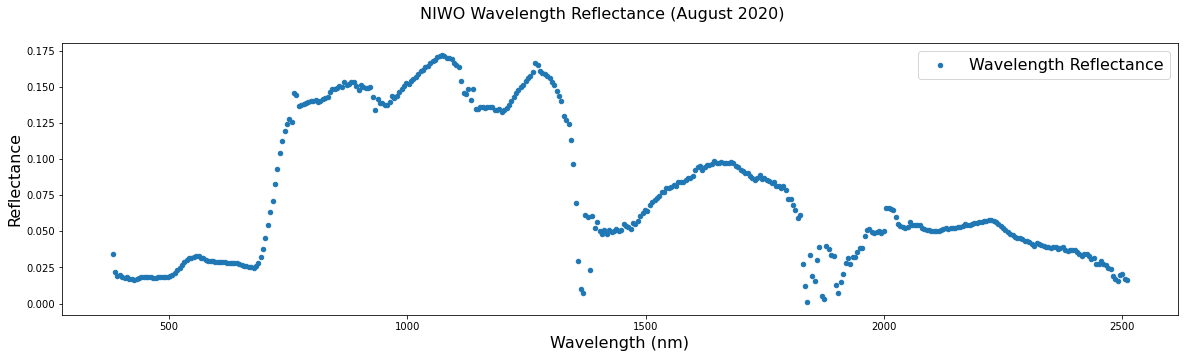

In [17]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

In [18]:
# Make boxes to overlay on waveform image that represent bands picked up by MicaSense
# Create boxes with box(minx, miny, maxx, maxy)
box_1 = box(444, 0.005, 472, 0.035)
box_2 = box(475, 0.005, 507, 0.035)
box_3 = box(531, 0.02, 545, 0.05)
box_4 = box(560, 0.02, 587, 0.05)
box_5 = box(650, 0.01, 666, 0.04)
box_6 = box(668, 0.01, 682, 0.04)
box_7 = box(705, 0.04, 715, 0.09)
box_8 = box(717, 0.05, 729, 0.1)
box_9 = box(740, 0.115, 758, 0.135)
box_10 = box(842, 0.135, 899, 0.165)

In [19]:
# Create list of boxes
box_list = [box_1, box_2, box_3, box_4, box_5, box_6, box_7, box_8, box_9, box_10]

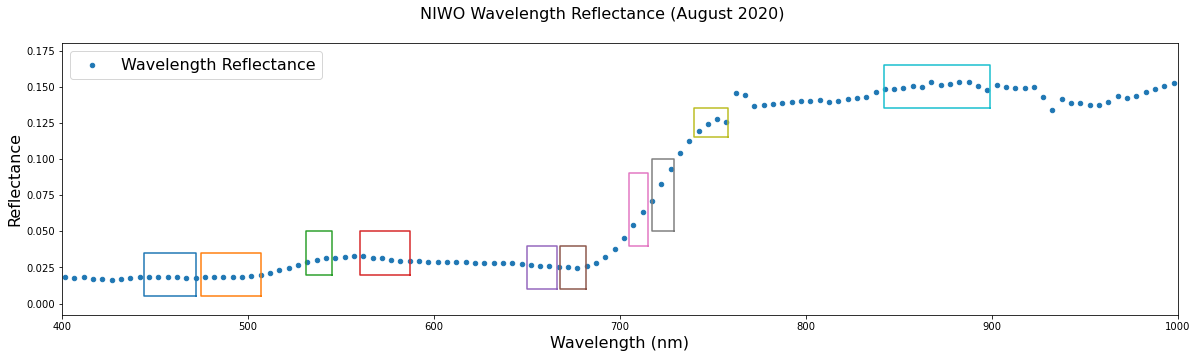

In [20]:
# Define figure space
fig, ax = plt.subplots(figsize=(20, 5))

# Plot wavelength
refl_df.plot(ax=ax, 
             x="wavelength",
             y="reflectance",
             kind="scatter", 
             label="Wavelength Reflectance",
             legend=True)

# Set title
fig.suptitle("NIWO Wavelength Reflectance (August 2020)", fontsize=16)

# Set x and y axis labels
plt.xlabel("Wavelength (nm)", fontsize=16)
plt.ylabel("Reflectance", fontsize=16)

# Add legend
ax.legend(prop={'size': 16})

# Restrict x-axis limits
ax.set_xlim([400, 1000])

# Add boxes using for loop
for box in box_list:
    plt.plot(*box.exterior.xy)

In [21]:
# Loop through reflectance array again to grab whole arrays
# Create empty list
full_refl_array = []
for band in np.arange(niwo_refl.shape[2]):
    refl_band = niwo_refl[:,:,band]
    full_refl_array.append(refl_band)

In [22]:
# Make another dataframe with wavelength and full reflectance array
refl_array_df = pd.DataFrame(
    {"wavelength": wavelengths,
     "reflectance": full_refl_array})
refl_array_df

,wavelength,reflectance
0,381.666992,"[[0.0, 0.0, 0.0777, 0.0011, 0.0, 0.0, 0.0538, ..."
1,386.674988,"[[0.0099, 0.0026, 0.0037, 0.0016, 0.0003, 0.01..."
2,391.683014,"[[0.0076, 0.0032, 0.0018, 0.0058, 0.0094, 0.00..."
3,396.691101,"[[0.0073, 0.006, 0.0014, 0.0059, 0.0042, 0.010..."
4,401.699097,"[[0.0062, 0.006, 0.0056, 0.0064, 0.0075, 0.012..."
...,...,...
421,2490.045410,"[[0.0, 0.0, 0.0, 0.0071, 0.0, 0.0, 0.0097, 0.0..."
422,2495.053223,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0049, 0.0122, 0.0..."
423,2500.061279,"[[0.0, 0.0, 0.0, 0.0, 0.0025, 0.0054, 0.0129, ..."
424,2505.069336,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0043, 0.0192..."


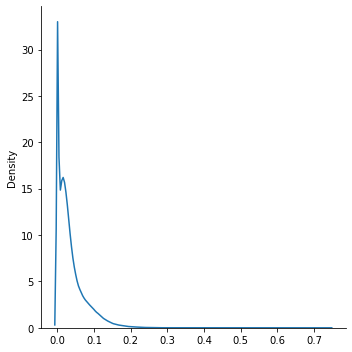

In [25]:
# Try seaborn
# This is a kde plot of reflectance for a single wavelength
sns.displot(full_refl_array[0].flatten(), kind='kde')

Let's back up a bit. I'm going to start with the refl_array_df object and filter the dataframe so that it only includes bands that are inside the boxes on the waveform plot above! We know which bands are inside the boxes due to the MicaSense Whitepaper! We want the numbers that fall within the boxes as follows:

1. 444, 472
2. 475, 507
3. 531, 545
4. 560, 587
5. 650, 666
6. 668, 682
7. 705, 715
8. 717, 729
9. 740, 758
10. 842, 899

In [27]:
# Encode the box bounds
boxes_bounds_df = pd.DataFrame(
    {'box' : [1, 2, 3, 4, 5, 6],
     'low' : [444, 475, 531, 560, 650, 668],
     'high': [472, 507, 545, 587, 666, 682]})


def get_between(
        low, high, df, col_between='wavelength', col_out='reflectance'):
    """Select rows of a dataframe column that fall between two values"""
    out = df[df[col_between].between(low, high)].reset_index()
    return out.get(col_out), out.get(col_between)

# Add reflectance arrays and wavelength sequences to the dataframe
boxes_bounds_df[['reflectance', 'wavelength']] = boxes_bounds_df.apply(
    lambda row: get_between(row.low, row.high, refl_array_df),
    axis=1,
    result_type='expand')

# Check it out
boxes_bounds_df

,box,low,high,reflectance,wavelength
0,1,444,472,"0 [[0.0049, 0.0025, 0.0024, 0.0056, 0.0053,...",0 446.771301 1 451.779297 2 456.78741...
1,2,475,507,"0 [[0.0029, 0.0009, 0.0013, 0.0033, 0.0035,...",0 476.819489 1 481.827515 2 486.83551...
2,3,531,545,"0 [[0.0028, 0.0019, 0.0025, 0.0042, 0.0049,...",0 531.907715 1 536.915710 2 541.92382...
3,4,560,587,"0 [[0.0031, 0.0019, 0.0024, 0.0048, 0.0058,...",0 561.955872 1 566.963928 2 571.97192...
4,5,650,666,"0 [[0.0016, 0.0005, 0.002, 0.0032, 0.0047, ...",0 652.100281 1 657.108276 2 662.11639...
5,6,668,682,"0 [[0.0016, 0.0006, 0.0004, 0.0028, 0.0046,...",0 672.132385 1 677.140381 Name: waveleng...


In [28]:
# Explode the dataframe into a tidy format
boxes_refl_df = (
    boxes_bounds_df
    .explode(['wavelength', 'reflectance'])
    .explode('reflectance')
    .explode('reflectance'))
boxes_refl_df

,box,low,high,reflectance,wavelength
0,1,444,472,0.0049,446.771301
0,1,444,472,0.0025,446.771301
0,1,444,472,0.0024,446.771301
0,1,444,472,0.0056,446.771301
0,1,444,472,0.0053,446.771301
...,...,...,...,...,...
5,6,668,682,0.0008,677.140381
5,6,668,682,0.0,677.140381
5,6,668,682,0.0,677.140381
5,6,668,682,0.0,677.140381


In [29]:
### TAKE A LOOK AT THE DATATYPE OF THE REFLECTANCE COLUMN! IT'S CATEGORICAL
boxes_refl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 0 to 5
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   box          int64 
 1   low          int64 
 2   high         int64 
 3   reflectance  object
 4   wavelength   object
dtypes: int64(3), object(2)
memory usage: 1.2+ GB


In [30]:
boxes_refl_df.reflectance = boxes_refl_df.reflectance.astype('float')
boxes_refl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000000 entries, 0 to 5
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   box          int64  
 1   low          int64  
 2   high         int64  
 3   reflectance  float64
 4   wavelength   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 1.2+ GB


In [91]:
boxes_refl_df.wavelength = (
    boxes_refl_df.wavelength
    .astype('float')
    .round(3))
boxes_refl_df

,box,low,high,reflectance,wavelength
0,1,444,472,0.0049,446.771
0,1,444,472,0.0025,446.771
0,1,444,472,0.0024,446.771
0,1,444,472,0.0056,446.771
0,1,444,472,0.0053,446.771
...,...,...,...,...,...
5,6,668,682,0.0008,677.140
5,6,668,682,0.0000,677.140
5,6,668,682,0.0000,677.140
5,6,668,682,0.0000,677.140


The next step is to plot the frequency distribution of the refelectance for each band, but it seems like I need to have a separate dataframe for each band in order to do this. See this site [here](https://www.geeksforgeeks.org/density-plots-with-pandas-in-python/) and this post [here](https://stackoverflow.com/questions/63258749/how-to-extract-density-function-probabilities-in-python-pandas-kde). So we have to split up the above dataframe into six different dataframes.

In [61]:
cmap = cm.get_cmap('Dark2', 6)
print(cmap(0))

(0.10588235294117647, 0.6196078431372549, 0.4666666666666667, 1.0)


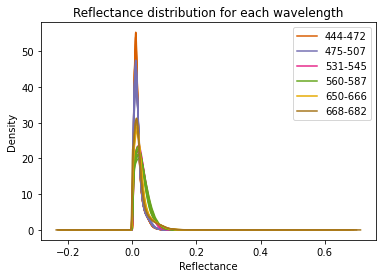

In [56]:
### THE KDE PLOTS ALL LOOK THE SAME. WHAT HAPPENS ON THE SAME AXIS?
### WE'LL ADD IN ALL THE BOXES, TO GET A CLEARER VIEW
# A plot
fig, ax = plt.subplots()

# Initialize legend values - avoid duplicate labels
legnd = OrderedDict()
cmap = cm.get_cmap('Dark2')

# Iterate through each wavelength - get individual values for bounds
groups = ['box', 'low', 'high', 'wavelength']
for (box, low, high, wavelength), band_df in boxes_refl_df.groupby(groups):
    # Generate legend entry
    label = '{}-{}'.format(low, high)
    color = cmap(box)
    legnd[label] = mlines.Line2D([], [], color=color)
    
    # Plot KDE
    band_df.reflectance.plot.kde(ax=ax, color=color, label=label)
    

ax.set_title('Reflectance distribution for each wavelength')
ax.set_xlabel('Reflectance')
plt.legend(legnd.values(), legnd.keys())

### THEY DO LOOK DIFFERENT, ESPECIALLY ACROSS BOXES

Let's plot the kernel density estimate (kde) now.

<function matplotlib.pyplot.legend(*args, **kwargs)>

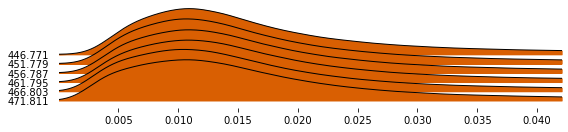

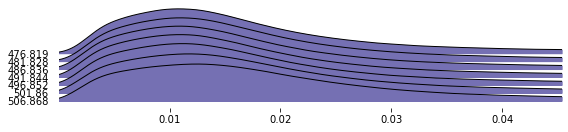

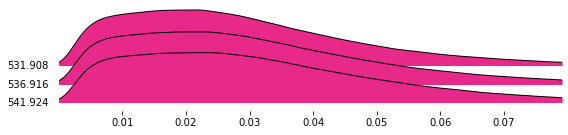

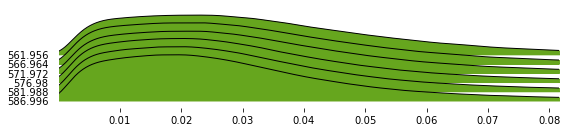

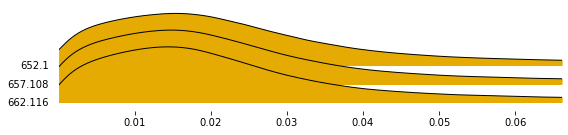

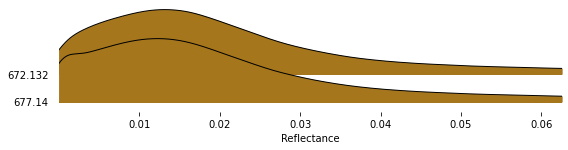

In [95]:
cmap = cm.get_cmap('Dark2')
for (box, box_df) in boxes_refl_df.groupby('box'):
    q3 = box_df.reflectance.quantile(.75)
    iqr = q3 - box_df.reflectance.quantile(.25)
    cutoff = q3 + 1.5 * iqr
    joypy.joyplot(
        box_df,
        column='reflectance', 
        by='wavelength',
        color=cmap(box), 
        x_range=(0, cutoff),
        linewidth=1,
        figsize=(8, 2))
    if box==0:
        plt.suptitle('Reflectance distribution for each wavelength')
plt.xlabel('Reflectance')
plt.legend